In [7]:
import tensorflow as tf
import read_cifar10 as cf10
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [8]:
import read_cifar10 as cf10

#@read_data.restartable
def cifar10_dataset_generator(dataset_name, batch_size, restrict_size=50000):
    assert dataset_name in ['train', 'test']
    assert batch_size > 0 or batch_size == -1  # -1 for entire dataset
    
    X_all_unrestricted, y_all = (cf10.load_training_data() if dataset_name == 'train'
                                 else cf10.load_test_data())
    
    actual_restrict_size = restrict_size if dataset_name == 'train' else int(1e10)
    #actual_restrict_size = 50000
    X_all = X_all_unrestricted[:actual_restrict_size]
    data_len = X_all.shape[0]
    batch_size = batch_size if batch_size > 0 else data_len
    
    X_all_padded = np.concatenate([X_all, X_all[:batch_size]], axis=0)
    y_all_padded = np.concatenate([y_all, y_all[:batch_size]], axis=0)
    
    for slice_i in range(math.ceil(data_len / batch_size)):
        idx = slice_i * batch_size
        #X_batch = X_all_padded[idx:idx + batch_size]
        X_batch = X_all_padded[idx:idx + batch_size]*255  # bugfix: thanks Zezhou Sun!
        y_batch = np.ravel(y_all_padded[idx:idx + batch_size])
        yield X_batch.astype(np.uint8), y_batch.astype(np.uint8)

cifar10_dataset_generators = {
    'train': cifar10_dataset_generator('train', 1000),
    'test': cifar10_dataset_generator('test', -1)
}

In [9]:
for iter_i,row in enumerate(cifar10_dataset_generator('train',1,10)):
    if iter_i == 0:
        image_1 = row[0]
    if iter_i == 1:
        image_2 = row[0]
    if iter_i == 2:
        break

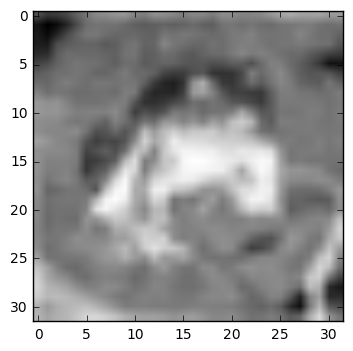

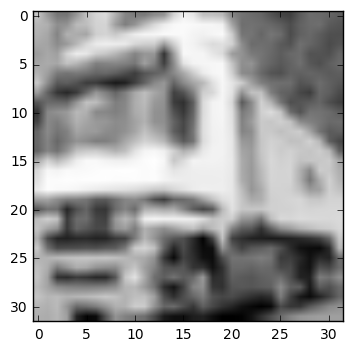

In [10]:
image = np.reshape(image_1,(32,32,3))
image_1 = (0.299*image[:,:,0] + 0.587*image[:,:,1] + 0.114*image[:,:,2])/255
image = np.reshape(image_2,(32,32,3))
image_2 = (0.299*image[:,:,0] + 0.587*image[:,:,1] + 0.114*image[:,:,2])/255
plt.imshow(image_1,cmap = cm.Greys_r)
plt.show()
plt.imshow(image_2,cmap = cm.Greys_r)
plt.show()

1.0


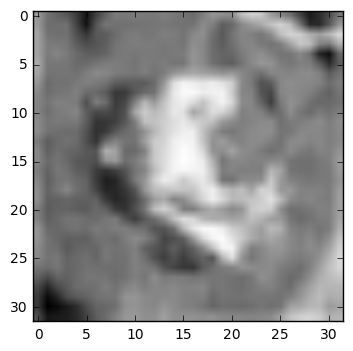

In [14]:
image_rot = np.rot90(image_1)
l_ = l_x_y(image_1,image_rot,0.0001)
c_ = c_x_y(image_1,image_rot,0.00001)
s_ = s_x_y(image_1,image_rot,0.0001)
print(l_*c_*s_)
plt.imshow(image_rot,cmap = cm.Greys_r)
plt.show()

In [11]:
#luminance computation
def l_x_y(x,y,C1):
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    numerator = (2*mean_x*mean_y) + (C1)
    denominator = (mean_x**2)+(mean_y**2)+C1
    return (numerator/denominator)

In [12]:
#contrast computation
def c_x_y(x,y,C2):
    std_x = np.std(x,ddof = 1)
    std_y = np.std(y,ddof = 1)
    numerator = (2*std_x*std_y) + C2
    denominator = (std_x**2) + (std_y**2) + C2
    return (numerator/denominator)

In [13]:
#structure of the image computation
def s_x_y(x,y,C3):
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    std_x = np.std(x,ddof = 1)
    std_y = np.std(y,ddof = 1)
    x_ = x - mean_x
    y_ = x - mean_y
    sigma_x_y = np.sum(x_ * y_)/((np.shape(x)[0]*np.shape(x)[1])-1)
    numerator = sigma_x_y + C3
    denominator = (std_x*std_y) + C3
    return (numerator/denominator)

In [63]:
#computing the Sstructural SImilarity Index Metrix
def compute_SSIM(image_1,image_2,l_exp,c_exp,s_exp):
    l_ = l_x_y(image_1,image_2,0.00001)
    c_ = c_x_y(image_1,image_2,0.00001)
    s_ = s_x_y(image_1,image_2,0.00001)
    l = l_**l_exp
    c = c_**c_exp
    s = s_**s_exp
    return (l*c*s)

In [67]:
#convolving through differnt parts of the image and taking the average
def convolve(image_1,image_2,stride = 8,l_exp = 1,c_exp = 1,s_exp = 1):
    count = 0
    SSIM = 0
    size_image_x = np.shape(image_1)[0]
    size_image_y = np.shape(image_1)[1]
    for stride_y in range(0,size_image_x-stride):
        for stride_x in range(0,size_image_y-stride):
            count = count + 1
            temp_image_1 = image_1[stride_y:(stride_y+stride),stride_x:(stride_x+stride)]
            temp_image_2 = image_2[stride_y:(stride_y+stride),stride_x:(stride_x+stride)]
            SSIM += compute_SSIM(temp_image_1,temp_image_2,l_exp,c_exp,s_exp)
    print("SSIM:",(SSIM/(count)))

In [68]:
#give two images for which SSIM has to be calculated
#l_exp is the parameter to adjust if emphasis has to be given to luminance(default = 1)
#c_exp is the parameter to adjust if emphasis has to be given to contrast(default = 1)
#s_exp is the paramter to adjust if emphasis has to be given to the shape(default = 1)
#stride is the number of square patches the convolution has to be performed(default = 8)

convolve(image_1,image_2)

SSIM: 0.628955288956
